# Import

In [69]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # F.mse_loss
import torch.optim as optim
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader  # for batch and split Xtrain Ytrain dataset
import sys
import torchviz
import scipy
import scipy.ndimage as nd
from scipy.stats import norm
from scipy.optimize import minimize

from locale import format
from dataclasses import dataclass, MISSING

import seaborn as sns
import plotly.graph_objects as go


from scipy.interpolate import griddata
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# from scipy.sparse import identity
from icecream import ic  # for debugging. print variable name

## !!!!! To get the parameters
#from gdrive.MyDrive.Github.PredictiveCoding.main.Src.PC_param import default_parameters_network

#from PC_param import default_parameters_network
#import PC_param.ipynb
#from PC_Parameters import default_parameters_network

## !!!!! To get the parameters
import sys
#sys.path.insert(1, '/Users/knzga/Documents/folder/02_Computational Neuroscience Project/Programming/VScode/PredictiveCoding/main/Src/PC_param.ipynb')
sys.path.insert(1, '/main/CustomPackages/PC_param.py')

#https://github.com/Nozasp/PredictiveCoding/blob/main/
#main/Src

#C:\Users\knzga\Documents\02_Computational Neuroscience Project\Programming\VScode\PredictiveCoding\main\Src> 
#from PC_param import default_parameters_network #from PC_param 
from PC_param import default_parameters_network

pars = default_parameters_network()


# Function

In [70]:

#### 2- Input/Output function

def plot_io(x, y, sign):
    if sign == "+":
        sign_name = 'Excitatory'
        label = "ae={0}, be={1}, hme={2}"
        a, b, hm = pars['ae'], pars['be'], pars['hme']
        color = "k"
    elif sign == "-":
        sign_name = 'Inhibitory'
        label = "ai={0}, bi={1}, hmi={2}"
        a, b, hm = pars['ai'], pars['bi'], pars['hmi']
        color = "r"

    plt.plot(x, y, color, label=label.format(a, b, hm))

    plt.xlabel("Input values - nA")
    plt.ylabel("Spike Frequency - Hz")
    plt.xlim([-0.01, 1])
    plt.title("Input-output function")
    # plt.title("{0} Input-output function".format(sign_name))
    plt.legend()


def plot_r(range_sim, r_e, r_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, r_e, "r", label=label_e.format(param.Jee, param.Jei))  # , param.I1 #, param.In
    plt.plot(range_sim, r_i, "orange", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)))

    plt.xlabel("Time - ms")
    plt.ylabel("Spike Frequency - Hz")
    if xlim_ar != None:
        plt.xlim(xlim_ar)  # [0, .1]
    plt.title("Firing rate of the NMDA and GABA populations")
    plt.legend()


def plot_s(range_sim, S_e, S_i, param, xlim_ar=None):
    label_e = "Excitatoty  Jee={0}, Jei={1}"  # , I1={2}"
    label_i = "Inhibitory  Jii={0}, Jie={1}"  # , I2={2}"
    plt.plot(range_sim, S_e, "olive", label=label_e.format(param.Jee, param.Jei))  # , param.I1
    plt.plot(range_sim, S_i, "green", label=label_i.format(param.Jii, param.Jie))  # , round(param.I2, 2)
    if xlim_ar != None:
        plt.xlim(xlim_ar)
    plt.xlabel("Time - ms")
    plt.ylabel("Open channel")
    # plt.xlim([0, .1])
    plt.title("Average open channel for the NMDA and GABA populations")
    plt.legend()


# 2- Plot HeatMap of firing rate function
def HeatMap(rE, rI, J=None):
    if J == None:
        J = [.00989, 0.0081, .1, .87, .00081]  # J = dict(Jin=.008, Jee= .2, Jie=.2, Jei=1.4, Jii=6.7)
    if type(J) == dict:
        J = np.array(list(J.values()))

    rE_df = pd.DataFrame(rE.T)  # to get time vs pop
    rI_df = pd.DataFrame(rI.T)
    rE_df.index = rE_df.index + 1
    rI_df.index = rI_df.index + 1
    rE_df.index.name, rI_df.index.name = ["Excitatory Population", "Inhibitory Population"]
    rE_df.columns.name, rI_df.columns.name = ["Time ms", "Time ms"]
    # print(rE_df.loc[[10]])

    # set context for the upcoming plot
    sns.set_context("notebook", font_scale=.8, rc={"lines.linewidth": 2.5, 'font.family': 'Helvetica'})

    fig, (axA, axB) = plt.subplots(2, 1, figsize=(6, 6))

    sns.heatmap(rE_df, ax=axA, cmap="viridis")
    sns.heatmap(rI_df, ax=axB)
    axA.set_title(f"Firing rate in Hz of exc populations over time. Jie: {J[2]}, Jee: {J[1]}, Jin: {J[0]}",
                  fontdict={"fontsize": 10})
    axB.set_title(f"Firing rate in Hz of inh populations over time. Jei: {J[3]}, Jii: {J[4]}",
                  fontdict={"fontsize": 10})
    plt.tight_layout()

    plt.show()


# Filters gauss and Dog and LoG
def gaussian_filter(s, N):
    k = np.arange(1, N + 1)
    n = 1 / (np.sqrt(2 * np.pi) * N * s)
    gaussW = n * np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * s ** 2))
    gaussW2 = gaussW / (.009 ** 2 / np.max(gaussW))  # 1
    return gaussW2


def dog_filter(sOut, N):
    sIn = sOut / 30
    k = np.arange(1, N + 1)
    gaussIn = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sIn ** 2))
    gaussOut = np.exp(-(k - k[:, np.newaxis]) ** 2 / (2 * sOut ** 2))
    dog = gaussOut - gaussIn
    if np.max(dog) == 0 or None:
        print('zero max')
        dog = 0
    else:
        dog = dog / (.042 ** 2 / np.max(dog))  # .0088
    return dog


def LoG_filter(s, N):
    x_lap = np.eye(N)
    lapl_filter = nd.gaussian_laplace(x_lap, sigma=(s, s))
    return lapl_filter


def dLogGaus(s=.61, N=20):
    dig = LoG_filter(s, N) + gaussian_filter(.019 * s, N)
    return dig


"""### Differentiable function for back propagation

To avoid non-differentiable araising from discontinuity of the function, I "relax" (smoothen) the where() expression by using a sigmoid instead
*   with grad_fn:
*   if I get : > <SumBackward1 object at 0x7f79da0b9520> # differentiable
*   else I get none
"""


def relu_stim(x, stim):
    return torch.nn.functional.relu(1.0 - torch.abs(x - stim),
                                    inplace=False)  # inplace = False to avoid implace operation




def Dirac(A, N=pars["NumN"]):
    y = scipy.signal.unit_impulse(N, idx=(torch.max(torch.argmax(A))))  # , dtype= <class 'float'>)
    return torch.tensor(y)



"""### Try Normalization to "make it proba"
"""


def make_it_proba(r_e):
    """sum_r_e = torch.sum(r_e, 1).reshape(r_e.shape[0], 1)
    prob_r = torch.div(r_e, sum_r_e)
    print(prob_r.grad_fn)
    prob_r[prob_r != prob_r] = 0.05"""  # to replace nan to 1/20 - to sum to 1
    # print("should sum to 1:", torch.sum(prob_r, 1)) #to check that it worked
    baseline = 1
    sum_r_e_and_baseline = torch.sum(r_e, 1).reshape(r_e.shape[0], 1) + baseline
    prob_r = torch.div(r_e + baseline, sum_r_e_and_baseline)

    return prob_r.reshape(r_e.shape[0], r_e.shape[1])  # log or not log?


def make_it_proba_1d(r_e):
    baseline = 1
    sum_r_e = torch.sum(r_e) + baseline
    prob_r = torch.div(r_e +baseline, sum_r_e)  # torch.transpose(r_e, dim0=0 ,dim1=1) poses a problem
    #prob_r[prob_r != prob_r] = 0.05  # to replace nan to 1/20 - to sum to 1
    print("should sum to 1:", torch.sum(prob_r)) #to check that it worked

    return prob_r


def log_proba(proba_r):
    return torch.log(proba_r)


"""### Try softmax to "make it proba"
"""


def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdims=True)

def softmax1D(x):
    return torch.exp(x) / torch.sum(torch.exp(x))

"""### Get the expected stimuli : matrix of 1 where stimuli 0 elsewhere"""


# find the stimuli for every X = stim dataset
# find the stimuli for every X = stim dataset
def get_stimuli_input(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax

def get_stimuli_input1D(X_train_tensor):  # input of the shape Xtrain_tensor[5,:,:]
    Xargmax = torch.argmax(X_train_tensor)#, dim=1)
    Xmax = torch.max(Xargmax)
    return Xmax


# replace where function by relu functio which is differentiable
def get_expected_Y_relu(X_train_tensor):
    x_t = torch.transpose(X_train_tensor, 0, 1)
    dirac_2d = torch.zeros(x_t.shape)
    stim = get_stimuli_input(
        X_train_tensor)  # input of the shape Xtrain_tensor[5,:,:] # here get_stimuli not differenciable

    for pop, t in enumerate(x_t):
        tpop = torch.tensor(pop)
        dirac_2d[pop, :] = torch.nn.functional.relu(1.0 - torch.abs(tpop - stim), inplace=False).requires_grad_(False)
    dirac_2d = torch.transpose(dirac_2d, 1, 0)
    return dirac_2d


def get_expected_Y_relu_1d_where(X_train_tensor):
    stim = get_stimuli_input1D(X_train_tensor)
    dirac_1d = torch.zeros(X_train_tensor.shape)
    # Calculate the difference between tpop and stim
    for pop in enumerate(X_train_tensor):
        dirac_1d[pop[0]] = torch.where(pop[0] == torch.tensor(stim), torch.tensor(1.0), torch.tensor(0.0)).requires_grad_(False)#true #not differenciable
    return dirac_1d



"""### Optimization function"""

#Make a function which save parameters of trained model and upload the new model with the updated parameters

def model_with_saved_trained_param(old_model, optimizer, Model):
    # or to save the parameters only
    torch.save(old_model.state_dict(),"Old_model_optimized_parameters.pth")
    torch.save(optimizer.state_dict(),"optimizer_optimized_parameters.pth")
    #load these parameters in a new model instance
    new_mymodel = Model()
    new_mymodel.load_state_dict(torch.load("Old_model_optimized_parameters.pth")) 
    optimizer.load_state_dict(torch.load('optimizer_optimized_parameters.pth'))

    #print(optimizer.param_groups[0]['params'])
    print("old model",old_model.Jee,"new model", new_mymodel.Jee)
    #print(optimizer.param_groups)
    #print(optimizer.state)
    return new_mymodel, optimizer




# function wich test the accuracy of a model with new parameters compared to expected results + loss values for every samples
def test_model(model, test_dataloader, loss_f):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            # Calculate output
            Y_prediction, _, dredt, dridt = model(x_test[0])
            #Y_prediction_prob = make_it_proba(Y_prediction)

            # Calculate loss
            #loss = loss_f(Y_prediction_prob, y_test[0], dredt, dridt)
            loss = loss_f(Y_prediction, y_test[0], dredt, dridt)

            # Accuracy
            predictions = Y_prediction.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            #predictions = Y_prediction_prob.detach().round() # rounds the predictions to the nearest integer (0 or 1), assuming they represent probabilities.
            correct_predictions += (predictions == y_test[0]).sum().item() # calculates the number of correct predictions by comparing the rounded predictions with the true labels (y_test). It sums up the correct predictions over the batch.
            total_samples += y_test[0].numel() # adds the total number of samples/item in the current batch to the overall count.

            test_loss += loss.item()

    accuracy = correct_predictions / total_samples
    average_loss = test_loss / len(test_dataloader)

    print(f'Test Accuracy: {accuracy:.4f}, Test Loss: {average_loss:.4f}')
    return accuracy, average_loss



# Classes

## Simple Classes

In [71]:




"""
*
*
***********  CLASS
*
*
"""


# ***************** CLASS ***************************************

@dataclass
class Parameter:
    # °°° Load the parameters °°°

    taue: float = pars["taue"]
    ae: float = pars['ae']
    be, hme, I_noise = pars['be'], pars['hme'], pars['I_noise']
    Jee: float = pars['Jee']
    taui, ai, bi, hmi = pars['taui'], pars['ai'], pars['bi'], pars['hmi']
    Jii: float = pars['Jii']
    Jei: float = pars['Jei']
    Jie: float = pars['Jie']
    Jes, Jsi = pars['Jes'], pars['Jsi']
    Jiq: float = pars['Jiq']  # 0.85; #nA
    Jin: float = pars['Jin']
    tauNMDA, tauAMPA, tauGABA = pars['tauNMDA'], pars['tauAMPA'], pars['tauGABA']
    gamma: float = pars['gamma']  # nmda coupling parameter from brunel
    c_dash = pars['c_dash']
    sigma = pars['sigma']  # param.sigma = .0007 for Noise
    I_noise = pars['sigma'] * np.random.randn(3, 1)
    I1 = pars['Jext'] * pars['mu0'] * (1 + pars['c_dash'] / 100)
    I2 = pars['Jext'] * pars['mu0'] * (1 - pars['c_dash'] / 100)
    # I1, I2 = pars['I1'], pars['I2']

    sigmaIn = pars['sigmaIn']

    # Input parameters
    In0 = pars['In0']  # % Spontaneous firing rate of input populations (Hz)
    InMax = pars['InMax']  # % Max firing rate of input populations (Hz)
    Iq0 = pars['Iq0']  # % Spontaneous firing rate of feedback populations (Hz)
    IqMax = pars['IqMax']  # % Max firing rate of feedback populations (Hz)

    # Gaussian filter
    # sIn = pars['sigmaInh'][0]
    # sOut = pars['sigmaInh'][1]

    def __init__(self, sEI, sIn, sOut, N):  # sEI=4, sIn=.2, sOut=1.2,
        # Weights (from gaussian filter)
        self.N = N  # pars['NumN']
        self.wei = torch.tensor(dog_filter(sOut, int(N)), dtype=torch.float32)   # .astype( torch.float32))  # , dtype='float64'# fun.dLogGaus(.61, N)  #fun.dog_filter(sIn, sOut, N)#gaussian_filter(sEI, N)
        self.wii = torch.tensor(np.eye(int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(sEI, int(N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(N)), dtype=torch.float32)  #.astype(torch.float32))  # Identity matrix
        self.f = np.arange(1, N + 1)
        self.sEI = sEI
        self.sIn = sIn
        self.sOut = sOut

    def reset(self):  # https://stackoverflow.com/questions/56878667/setting-default-values-in-a-class

        for name, field in self.__dataclass_fields__.items():
            if field.default != MISSING:
                setattr(self, name, field.default)
            else:
                setattr(self, name, field.default_factory())


# °°° Time of the simulation °°°
class Simulation:
    def __init__(self, dt, T):
        self.dt = dt
        self.T = T
        self.range_t = (np.arange(0, self.T, self.dt))
        self.Lt = self.range_t.size

    def printSim(self):
        print("T time step of the simulation (dt): ", self.dt, "  Duration of simulation S (T): ", self.T,
              "Length of the time frame (Lt): ", self.Lt)


#  °°° Initialisation of the variables °°°

class Stim:
    def __init__(self, param, simu, f, ISI=0.5, dur=0.2): #ISI=1, dur=0.2   # 8 #[10]
        self.f = f  # array of frequency stimulus types
        self.ISI = ISI  # inter-stimulus interval
        self.dur = dur  # duration in s of a specific stimulus segment . The time the frequency fi ll be maintained in the f array
        self.tail = 0
        self.predDt = 0
        self.pred = 0
        self.InMax = param.InMax
        self.In0 = param.In0

        # Instantaneous frequency
        #f_instant = np.zeros((int(self.ISI / simu.dt) + 1, 1))  # size ISI : 1 /dt : 1000

        for fx in self.f:
            fx_array = np.concatenate((np.ones((int(self.dur / simu.dt), 1)) * fx,
                                       # just 1 frequency of 8 . # inter-stim interval is aslong as stim interval
                                       np.zeros((int(self.ISI / simu.dt),
                                                 1))))  # so I get 1 list with 1000 lists containing 8 and 1000 lists containing 0
        f_stim = fx_array # np.vstack((f_instant, fx_array))  # stack vertically these arrays # [0] *1000 , [8]*1000, [0]*1000
        self.f_stim = f_stim[1:]  # 1400*1

    # bottom up sensory Input # duration 1sec
    def sensoryInput(self, parameter, simu, sigmaIn=None, paramf=None, f_stim=None, InMax=None, In0=None):
        # paramf = np.arange(1, 101)
        w = np.exp(-(((paramf or parameter.f) - (f_stim or self.f_stim)) ** 2) / (
                2 * (sigmaIn or parameter.sigmaIn) ** 2))  # pars['f'] = 1:N

        # totalAct = w.sum(axis = 1) #sum over each row
        # norm_w = (w.T / totalAct).T # elementwise division
        In = np.where(f_stim or self.f_stim > 0, (InMax or self.InMax) * w + (In0 or self.In0),
                      0)  # if stim >0 give InMax * weight + In0 otherwise give 0
        if self.tail != 0:
            tail_zeros = np.zeros((parameter.N, int(self.tail / simu.dt)))
            In = np.hstack((In, tail_zeros))

        range_sim = np.arange(1, In.shape[0] + 1)
        self.In = In
        self.w = w
        self.sigmaIn = sigmaIn

        return In, range_sim, w, sigmaIn

    def printStim(self):
        print("frequence of stimulus f:", self.f, "  ISI:", self.ISI, " Size In:", self.In.shape, "Size w:",
              self.w.shape, "  f_stim:", self.f_stim.shape,
              "sigmaIn:", self.sigmaIn)




## Class Model

In [72]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class MyModel_time(nn.Module):
    def __init__(self):
        super(MyModel_time, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.072, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.004, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.05, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.6, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00695, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulan =torch.mul(a, I_tot)

        multi= mulan + b

        expo = torch.exp(- (multi))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




# Create stimuli Input

tensor(49.4258, grad_fn=<MaxBackward1>)


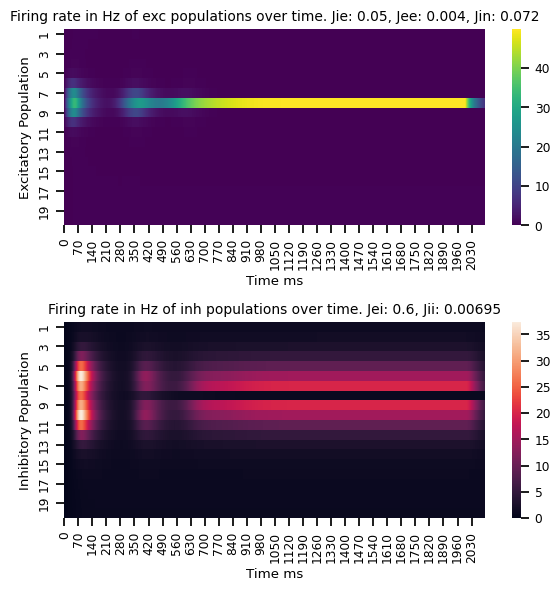

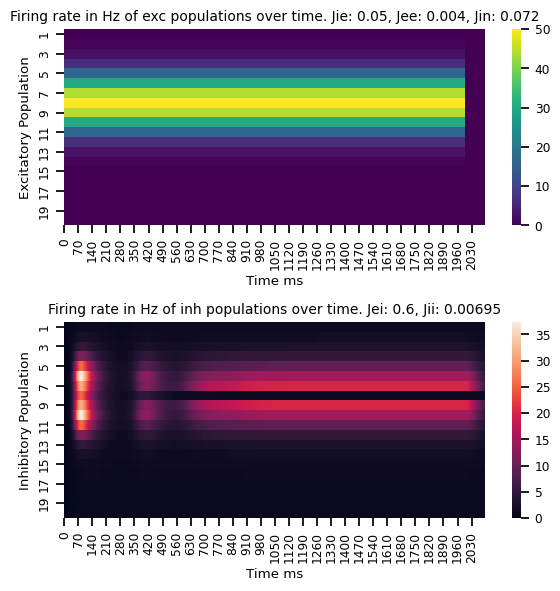

In [73]:
"""
*
*  Creat IN and Forward pass
*
*
"""


    ## Parameters used to create In
N = 20
# \\\\\\\\\\\ Parameters
param = Parameter(N=20, sIn=.1, sOut=3., sEI=.2)
# \\\\\\\\\\\ Simulation time
simu = Simulation(1e-4, 2)  # dt #rangeSim #dur = 2s

# \\\\\\\\\\\ Bottom up sensory input
stimuli = Stim(param, simu, dur=.2, f=[8], ISI=.01) #dur=.3 ,ISI=.05    # dur = 1s Isi=1s
In, range_sim, w, sigmaIn = stimuli.sensoryInput(param, simu, sigmaIn=2.) #2.

J1 = {'Jee': 0.072, 'Jei': 0.004, 'Jie': 0.05, 'Jii': 0.6, 'Jin': 0.00695}
J_list = list(J1.keys())

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mymodel = MyModel_time()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e, r_i, dredt, dridt = mymodel.forward(sti)
print(torch.max(r_e[1000,:]))
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)
HeatMap(sti.detach().numpy(), r_i.detach().numpy(), J1)

# Optimization part

### Space for Loss design

In [74]:
def custom_loss_(re, Target, derivativeE, derivativeI):
  Cost = torch.tensor(0.0)
  
  #1/ Proba term
  Pred = make_it_proba(re)
  loss_proba = torch.zeros((Pred.shape))
  for t in range(Pred.shape[0]):
    target_pop_long = Target.select(0,t).long() #[t,:], dtype = torch.long)
    log_pred_pop = (Pred.select(0,t))#torch.log # Pred.select(0,t) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)
    # Calculate loss by comparing the distribution to the expected probabilities
    loss_proba[t,:] = F.nll_loss(log_pred_pop, target_pop_long)#, reduction='none')  #negative log likelihood # why reduction = none???
  #ic(loss_proba)
  ### Sum over time step
  total_loss_proba = torch.sum(loss_proba)
  #ic(total_loss_proba)
  
  #2/ derivative good 
  stimu_pop= torch.argmax(Target).item()
  ### for excitatory neurons # targe = -derivative other ?
  tensor_for_cost_derivative_E = derivativeE.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_E[:,stimu_pop] = - derivativeE.select(1, stimu_pop) #we want it to be negative for the stimulated population
  #ic(tensor_for_cost_derivative_E.grad_fn)
  
  ### for inhibitory neurons
  tensor_for_cost_derivative_I = derivativeI.clone() # torch.zeros((r_e.shape))
  tensor_for_cost_derivative_I = - derivativeI
  tensor_for_cost_derivative_I[:, stimu_pop] = - derivativeI.select(1, stimu_pop) #[:,stimu_pop]) #tensor_for_cost_derivativeI = [i for i in derivativeI if i not in target_arr]

  """loss_derivative = torch.add(torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)), #mean over popululation #then sum over every time step
                              torch.sum(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)))"""
  #mean instead of sum over time step
  loss_derivative = torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_E)**2, axis = 1)) + torch.mean(torch.mean(F.softplus(tensor_for_cost_derivative_I)**2, axis = 1)) #mean over popululation #then sum over every time step
  
  #3/ L2 regu term
  l2_reg_coef=0.001
  l2_reg = 0.0
  for param in mymodel.parameters():
      l2_reg += torch.sum(param**2)
  
  #4/ High value of re term
  # I have to change that !! firing rate still decreased after loss
  high_activity_penalty_coef=0.01
  ic(torch.max(re[:,stimu_pop]))

  if torch.max(re[:,stimu_pop]) > 60:
     high_activity_penalty = torch.sum(torch.sum(re[:, stimu_pop]**2)) #torch.clamp(r_e[:, 7], max=10.0
  else:
     high_activity_penalty = 0
    
  #Cost = loss_derivative + total_loss_proba    #loss_proba + loss_derivative
  Cost = (l2_reg * l2_reg_coef)
  Cost_f = - loss_derivative - total_loss_proba + (high_activity_penalty * high_activity_penalty_coef) + Cost #Cost_f+ 
  ic(type(Cost_f))
  return Cost_f


### Optimization Loop function

In [75]:
def easyLoss(Y_pred_prob,target):
    #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))
    return torch.mean((Y_pred_prob - target)**2)

def optimizerloop(model, input, target, loss_f, Opt_name,learningRate, num_epoch):
    losses = torch.zeros(num_epoch) # used to plot the loss at the end
    
    if Opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(),
                      lr=learningRate, weight_decay = 0.1)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    elif Opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(),
                      lr=learningRate)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    
    model.train()
    for epoch in range(num_epoch):
        # Clear the gradients
        optimizer.zero_grad()

        # calculate output
        Y_prediction, I, dredt, dridt = model(input)
  
        # calculate loss
        #Y_prediction_prob = make_it_proba(Y_prediction)
        #loss = torch.sum(torch.sum((Y_prediction_prob-Y_target), axis =1))# (torch.mean((Y_prediction_prob - Y_target)**2))
        #loss = loss_f(Y_prediction_prob, target) #t
        #loss = custom_loss_(Y_prediction_prob, target , dredt, dridt)#torch.mean
        loss = loss_f(Y_prediction, target , dredt, dridt)#torch.mean
        #ic(loss.grad_fn)
        loss.backward()

        optimizer.step()

        losses[epoch] = loss
        
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}, Loss_grad: {loss.grad_fn}')  # .item()
    for i, par in enumerate(model.parameters()):
        ic(J_list[i], par, par.grad)
           

    return list(model.parameters()), losses, optimizer

In [76]:
# +++++++++++++++++++++++++ Inputs + Labels +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
X_input = sti
#Y_prediction_prob =
Y_target = get_expected_Y_relu(X_input) #get the expected dirac delta for our particular Input

#print(custom_loss_(r_e, Y_target, dredt, dridt))

In [54]:
#SGD + Mean Loss
num_epochs = 10
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_

ic| total_loss_proba: tensor(-1333.1232, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(53.4248, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1332.0635, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(53.5920, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1331.0200, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(53.7586, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1329.9910, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(53.9246, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1328.9772, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.0900, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1327.9785, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.2549, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1326.9948, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.4192, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1326.0256, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.5829, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1325.0712, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.7461, grad_fn=<MaxBackward1>)


ic| total_loss_proba: tensor(-1324.1311, grad_fn=<SumBackward0>)
ic| type(Cost_f): <class 'torch.Tensor'>


tensor(54.9088, grad_fn=<MaxBackward1>)


ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0723, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-318294.3033, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0042, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-1.5367e+08, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0497, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(4949310.2499

Epoch [10/10], Loss: -429794.06213247497, Loss_grad: <AddBackward0 object at 0x0000022449D34970>


, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5998, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(166983.0845, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0073, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-3.5885e+08, dtype=torch.float64)


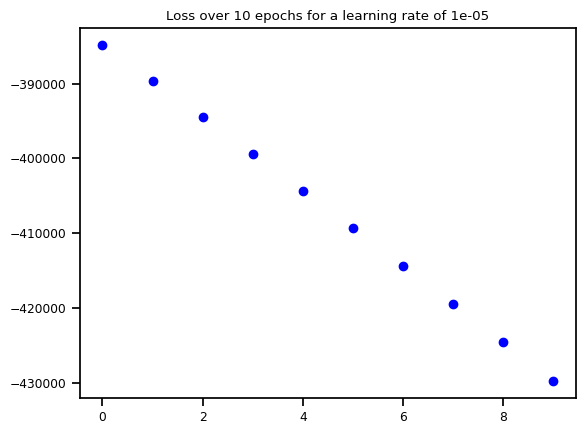

In [55]:
plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

# Work with custom loss proba term and neg log likelihood

In [97]:
def optimizerloop(model, input, target, loss_f, Opt_name,learningRate, num_epoch):
    losses = torch.zeros(num_epoch) # used to plot the loss at the end
    
    if Opt_name == "SGD":
        optimizer = optim.SGD(model.parameters(),
                      lr=learningRate, weight_decay = 0.1)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    elif Opt_name == "Adam":
        optimizer = optim.Adam(model.parameters(),
                      lr=learningRate)#, weight_decay = 0.00001) #, weight_decay = 0.00001)#, weight_decay = 0.001)#0.989
    
    model.train()
    for epoch in range(num_epoch):
        # Clear the gradients
        optimizer.zero_grad()

        # calculate output
        Y_prediction, I, dredt, dridt = model(input)
  
        # calculate loss
        loss = loss_f(Y_prediction, target)#torch.mean
        #ic(loss.grad_fn)
        loss.backward()

        optimizer.step()

        losses[epoch] = loss
        
    print(f'Epoch [{epoch + 1}/{num_epoch}], Loss: {loss}, Loss_grad: {loss.grad_fn}')  # .item()
    for i, par in enumerate(model.parameters()):
        ic(J_list[i], par, par.grad)
           

    return list(model.parameters()), losses, optimizer

In [136]:
def custom_loss_2(re, Target):
  Cost = torch.tensor(0.0)
  
  #1/ Proba term
  Pred = make_it_proba(re)
  loss_proba = torch.zeros((Pred.shape[0]))
  for t in range(Pred.shape[0]):
    target_pop_long = Target.select(0,t).long() #[t,:], dtype = torch.long)
    log_pred_pop = (Pred.select(0,t))#torch.log # Pred.select(0,t) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)
    # Calculate loss by comparing the distribution to the expected probabilities
    loss_proba[t] = F.nll_loss(log_pred_pop, target_pop_long)#, reduction='none')  #negative log likelihood # why reduction = none???
  ic(loss_proba)
  ### Sum over time step
  total_loss_proba = torch.sum(loss_proba)
  #ic(total_loss_proba)
  
  Cost_f = total_loss_proba 
  return Cost_f, loss_proba

In [137]:
data = torch.randn(5, 16, 10, 10)
target = torch.empty(5, 8, 8, dtype=torch.long).random_(0, 4) # 5 * 8 *8
data
#target
target_pop_long = Y_target.select(0,1000).long() #[t,:], dtype = torch.long)
log_pred_pop = (X_input.select(0,1000))#torch.log # Pred.select(0,t) # change with Alex instead of: torch.log(Pred.select(0,t))#input = log(probability)
# Calculate loss by comparing the distribution to the expected probabilities
loss_proba = F.nll_loss(log_pred_pop, target_pop_long)
print(loss_proba)

cost, loss_proba = custom_loss_2(X_input,Y_target)

tensor(-0.8906)


ic| loss_proba: tensor([ 0.0145,  0.0145,  0.0145,  ..., -0.1000, -0.1000, -0.1000])


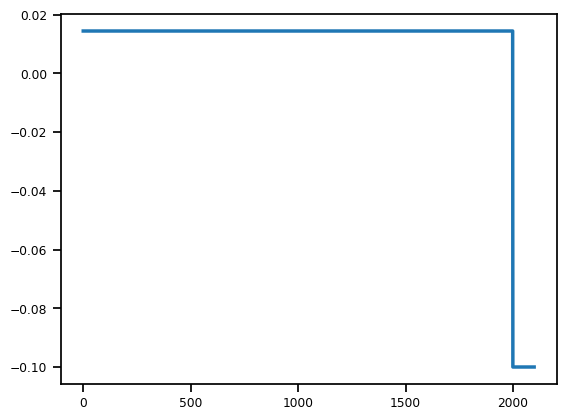

In [139]:
plt.plot(np.arange(loss_proba.shape[0]), loss_proba)

tensor(49.4258, grad_fn=<MaxBackward1>)


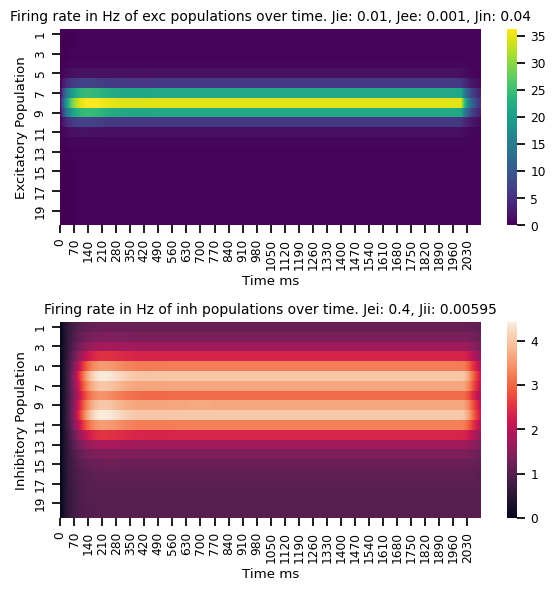

In [ ]:
"""
*
*  Forward pass for bad parameter
*
*
"""

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mybadmodel = BadParamModel()
J_bad = {'Jee': mybadmodel.Jee.detach().numpy(), 'Jei': mybadmodel.Jei.detach().numpy(), 'Jie': mybadmodel.Jie.detach().numpy(), 'Jii': mybadmodel.Jii.detach().numpy()
      , 'Jin': mybadmodel.Jin.detach().numpy()}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_bad, r_i_bad, dredt_bad, dridt_bad = mybadmodel.forward(sti)
print(torch.max(r_e[1000,:]))
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)

In [113]:
def negative_loglikelihood(x, y, theta):
    J = np.sum(-y * x * theta.T) + np.sum(np.exp(x * theta.T))+ np.sum(np.log(y))
    return J


def neg_log_lhood(a, y):
    mask = torch.tensor(y.clone().detach(), dtype=bool)
    na = (a)
    na[mask] = (na[mask]) #np.log10
    na[~mask] = (1 - na[~mask])#np.log10
    return - torch.sum(na) #-

y = [0 ,0, 1, 1, 0]
a = [0.2, 0.4, 0.6, 0.8, 0.1]

#neg_log_lhood(a, y)
neg_log_lhood(X_input, Y_target)

C:\Users\knzga\AppData\Local\Temp\ipykernel_12740\3774325095.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(y.clone().detach(), dtype=bool)


tensor(-261256.0625)

In [114]:
mask = np.asarray(Y_target, dtype=bool)
na = np.array(X_input)

print((na[mask]))
print(na[~mask])

[50. 50. 50. ...  0.  0.  0.]
[ 0.8906255   0.44455016 -1.1968467  ...  1.          1.
  1.        ]


In [115]:
#SGD + Mean Loss
num_epochs = 10
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new2, losses_list2,optimizer2 = optimizerloop(mymodel, X_input, Y_target, neg_log_lhood, "Adam",lr, num_epochs) # easyLoss #custom_loss_

C:\Users\knzga\AppData\Local\Temp\ipykernel_12740\3774325095.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(y.clone().detach(), dtype=bool)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0719, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(67585.3718, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0041, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(290345.3694, dtype=torch.float64)


Epoch [10/10], Loss: 132817.6875, Loss_grad: <SumBackward0 object at 0x00000223B52B8370>


ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0501, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-343545.7873, dtype=torch.float64)
ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.5999, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(1434.4294, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0068, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(35762050.2086, dtype=torch.float64)


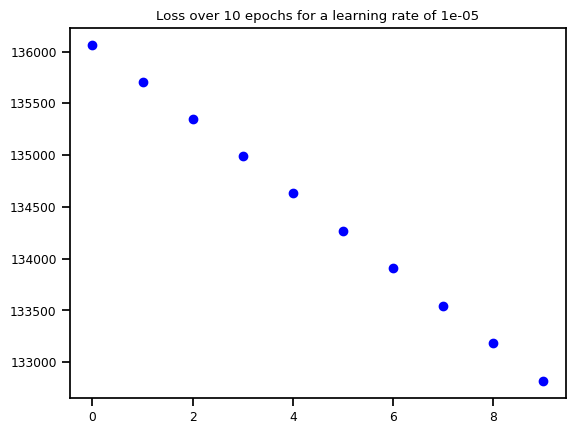

In [116]:
plt.plot(np.arange(losses_list2.shape[0]), losses_list2.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show() #-1410 with regular proba term and regular loss function
#-104000 with home made neg likelihood

# Save trained parameters and use them in a new model

old model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0719, dtype=torch.float64, requires_grad=True)


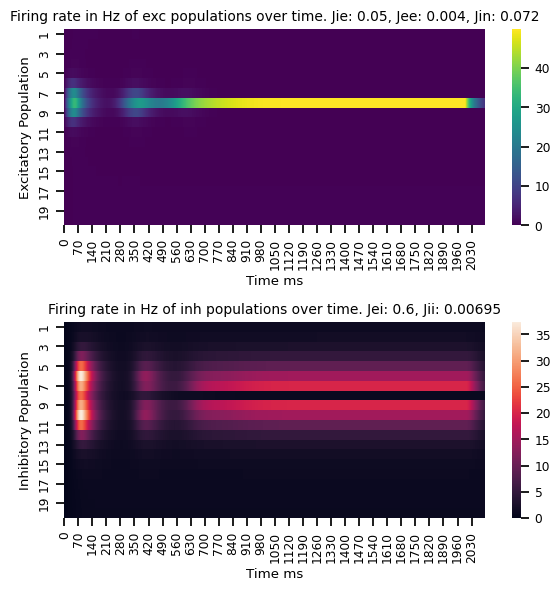

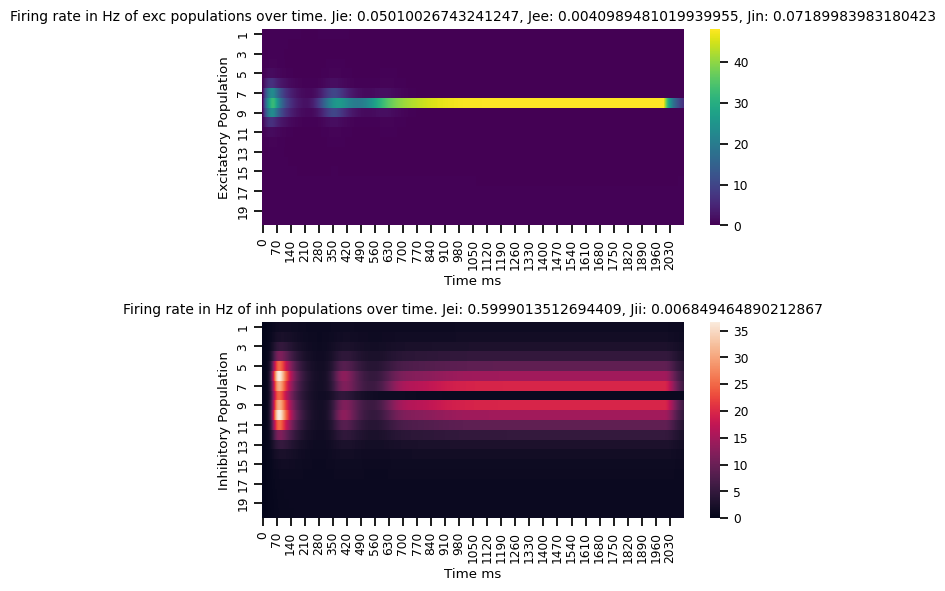

In [117]:
#Use a function which save parameters of trained model and upload the new model with the updated parameters


trained_model, optimizer_trained = model_with_saved_trained_param(mymodel, optimizer2, MyModel_time)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

r_e_trained, r_i_trained, dredt_trained, dridt_trained = trained_model.forward(sti) #Xtrain_tensor[2,:,:]

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e.detach().numpy(), r_i.detach().numpy(), J1)

J2= {'Jee': trained_model.Jee.detach().numpy(), 'Jei': trained_model.Jei.detach().numpy(), 'Jie': trained_model.Jie.detach().numpy(), 'Jii': trained_model.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e_trained.detach().numpy(), r_i_trained.detach().numpy(), J2)


# Do the test with new parameters

### bad parameter

In [118]:
"""
*
*
***********  CLASS MYMODEL
*
*
"""


class BadParamModel(nn.Module):
    def __init__(self):
        super(BadParamModel, self).__init__()

        #--- Define other model parameters, layers, or components here if needed
        self.dt = torch.tensor(1e-4) #sim.dt
        self.N = 20
        self.taue = self.taui = torch.tensor(0.005)
         # ¤ parameter of the phi function Not tweakable parameters
        self.ae = torch.tensor(18.26)  # 2 #Wong have to check # Modelling and Meg Gain of the E populaiton
        self.be = torch.tensor(-5.38)  # Threshold of the E populaiton
        self.hme = torch.tensor(78.67)
        self.ai = torch.tensor(21.97)
        self.bi = torch.tensor(-4.81)
        self.hmi = torch.tensor(125.62)
        #create the smallest possible number
        self.epsilon = sys.float_info.epsilon

        self.sIn = torch.tensor(.1)
        self.sOut= 3.
        self.sEI = .2
        self.tauAMPA = torch.tensor(0.002)
        self.tauGABA = torch.tensor(0.005)

        self.wei = torch.tensor(dog_filter(self.sOut, int(self.N)), dtype=torch.float32)
        self.wii = torch.tensor(np.eye(int(self.N)), dtype=torch.float32) # dog_filter(sIn, sOut, N)#np.eye(N) #
        self.wie = torch.tensor(gaussian_filter(self.sEI, int(self.N)), dtype=torch.float32) #.astype(torch.float32))  # dog_filter(sIn, sOut, N)
        self.wes = torch.tensor(np.eye(int(self.N)), dtype=torch.float32)  # Identity matrix


        # initial parameters
        self.Jee = nn.Parameter(torch.tensor(0.04, requires_grad= True, dtype= torch.float64))#, requires_grad=False, dtype=torch.float32)#I replaced .072 by 0.072
        #ic(self.Jee.grad_fn) #should be none
        self.Jei = nn.Parameter(torch.tensor(0.001, requires_grad= True, dtype= torch.float64))
        self.Jie = nn.Parameter(torch.tensor(0.01, requires_grad=True, dtype=torch.float64))
        self.Jii = nn.Parameter(torch.tensor(0.4, requires_grad=True, dtype=torch.float64))
        self.Jin = nn.Parameter(torch.tensor(0.00595, requires_grad= True, dtype=torch.float64))


    def phi(self, I_tot, a, b, hm): #)))  # this use a lot of memory - exponential part
        #multi= torch.nan_to_num((torch.mul(a, I_tot) + b), nan = self.epsilon, posinf=140, neginf=self.epsilon)

        for i in range(I_tot.shape[0]):
                if torch.isnan(I_tot[i])== True:
                    ic(I_tot, i)
                    quit()
                    sys.exit() #sys.

        mulan =torch.mul(a, I_tot)

        multi= mulan + b

        expo = torch.exp(- (multi))  #.abs()+ self.epsilon)
        return torch.multiply(hm, torch.divide(1, (1+ expo)))

    def forward(self, In):
        #--- Initialize model variables here
        prev_r_e = torch.zeros((In.shape[0], self.N)) # torch.ones(self.N) shows more obvious results
        prev_r_i = torch.zeros((In.shape[0], self.N))
        prev_s_ampa = torch.zeros((In.shape[0], self.N))
        prev_s_gaba = torch.zeros((In.shape[0], self.N))
        dr_e_dt = torch.zeros((In.shape[0], self.N))
        dr_i_dt = torch.zeros((In.shape[0], self.N))
        s_ampa = torch.tensor(0.)
        i_tot_e = torch.tensor(0.)
        i_tot_i = torch.tensor(0.)

        for k in range(1, In.shape[0]):
            #--- Compute values of interest
            #the operation Jee_re = self.Jee * prev_r_e => triggers inplace error
            s_gaba_wie = prev_s_gaba[k-1,:] @ self.wie
            s_ampa_wei = prev_s_ampa[k-1,:] @ self.wei
            s_gaba_wii = prev_s_gaba[k-1,:] @ self.wii
            JeeAmpa =  torch.mul(self.Jee, s_ampa)
            i_tot_e = torch.add(torch.subtract(JeeAmpa, torch.mul(self.Jie, s_gaba_wie)), torch.mul(self.Jin, In[k - 1, :]))
            i_tot_i = torch.subtract(torch.mul(self.Jei, s_ampa_wei), torch.mul(self.Jii, s_gaba_wii))

            phi_arr_e = self.phi(i_tot_e, self.ae, self.be, self.hme)
            phi_arr_i = self.phi(i_tot_i, self.ai, self.bi, self.hmi)

            dr_e_dt[k,:] = (-prev_r_e[k - 1, :] + phi_arr_e) / self.taue
            dr_i_dt[k,:] = (-prev_r_i[k - 1, :] + phi_arr_i) / self.taui

            r_e = prev_r_e[k - 1, :] + dr_e_dt[k,:] * self.dt
            r_i = prev_r_i[k - 1, :] + dr_i_dt[k,:] * self.dt

            dS_amp_dt = (- prev_s_ampa[k - 1, :] / self.tauAMPA) + r_e
            s_ampa = prev_s_ampa[k - 1, :] + dS_amp_dt * self.dt

            dS_gab_dt = (- prev_s_gaba[k - 1, :] / self.tauGABA) + r_i
            s_gaba = prev_s_gaba[k - 1, :] + dS_gab_dt * self.dt

            prev_r_e[k,:] = r_e
            prev_r_i[k,:] = r_i
            prev_s_ampa[k,:] = s_ampa
            prev_s_gaba[k,:] = s_gaba


        return prev_r_e, prev_r_i, dr_e_dt, dr_i_dt




tensor(49.4258, grad_fn=<MaxBackward1>)


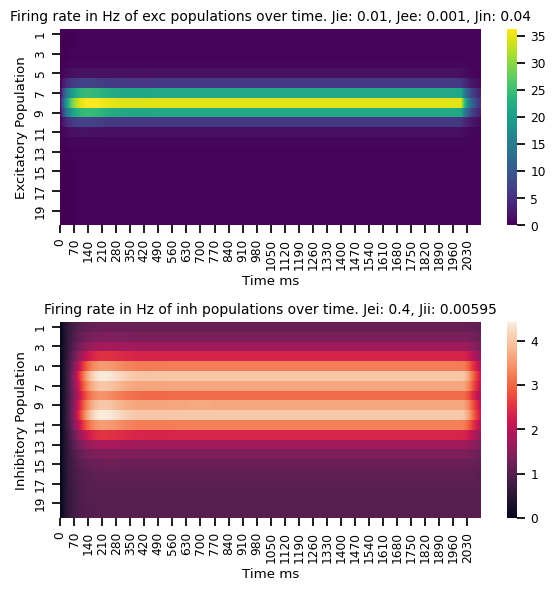

In [119]:
"""
*
*  Forward pass for bad parameter
*
*
"""

# +++++++++++++++++++++++++ Initialize the Model ++++++++++++++++++++++++++++
mybadmodel = BadParamModel()
J_bad = {'Jee': mybadmodel.Jee.detach().numpy(), 'Jei': mybadmodel.Jei.detach().numpy(), 'Jie': mybadmodel.Jie.detach().numpy(), 'Jii': mybadmodel.Jii.detach().numpy()
      , 'Jin': mybadmodel.Jin.detach().numpy()}

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sti = torch.tensor(stimuli.In, dtype=torch.float32)
r_e_bad, r_i_bad, dredt_bad, dridt_bad = mybadmodel.forward(sti)
print(torch.max(r_e[1000,:]))
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)

In [120]:
#SGD + Mean Loss
num_epochs = 20
lr = .00001

#param_new, losses_list,optimizer = optimizerloop(mymodel, X_input, Y_target, custom_loss_, "Adam",lr, num_epochs) # easyLoss #custom_loss_
param_new, losses_list,optimizer = optimizerloop(mybadmodel, X_input, Y_target, neg_log_lhood, "Adam",lr, num_epochs) # easyLoss #custom_loss_ #custom_loss_

C:\Users\knzga\AppData\Local\Temp\ipykernel_12740\3774325095.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(y.clone().detach(), dtype=bool)
ic| J_list[i]: 'Jee'
    par: Parameter containing:
         tensor(0.0398, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(50508.3369, dtype=torch.float64)
ic| J_list[i]: 'Jei'
    par: Parameter containing:
         tensor(0.0008, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(105946.5442, dtype=torch.float64)
ic| J_list[i]: 'Jie'
    par: Parameter containing:
         tensor(0.0102, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(-317445.5715, dtype=torch.float64)


Epoch [20/20], Loss: 102501.203125, Loss_grad: <SumBackward0 object at 0x00000223B5298940>


ic| J_list[i]: 'Jii'
    par: Parameter containing:
         tensor(0.3998, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(303.0680, dtype=torch.float64)
ic| J_list[i]: 'Jin'
    par: Parameter containing:
         tensor(0.0058, dtype=torch.float64, requires_grad=True)
    par.grad: tensor(36649700.9349, dtype=torch.float64)


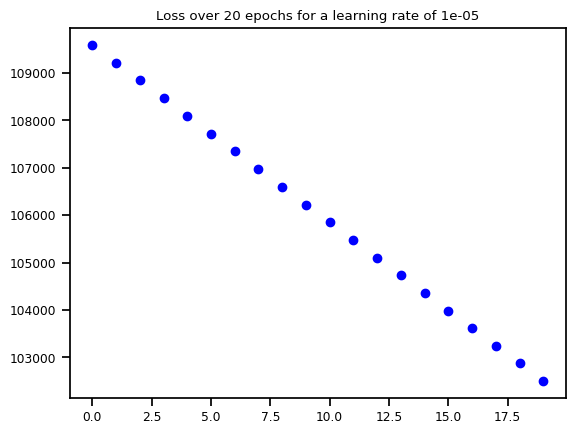

In [121]:
plt.plot(np.arange(losses_list.shape[0]), losses_list.detach().numpy(), 'bo', label='Training loss')
plt.title(f"Loss over {num_epochs} epochs for a learning rate of {lr}")
plt.show()

old model Parameter containing:
tensor(0.0398, dtype=torch.float64, requires_grad=True) new model Parameter containing:
tensor(0.0398, dtype=torch.float64, requires_grad=True)


ic| torch.max(r_e_bad): tensor(36.3049, grad_fn=<MaxBackward1>)
ic| torch.max(r_e_bad_trained): tensor(33.5169, grad_fn=<MaxBackward1>)


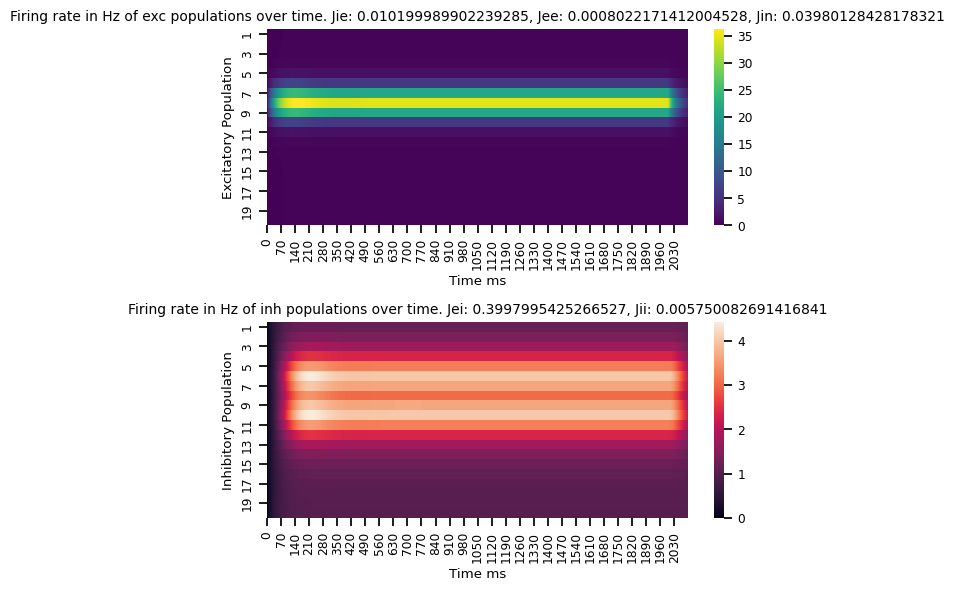

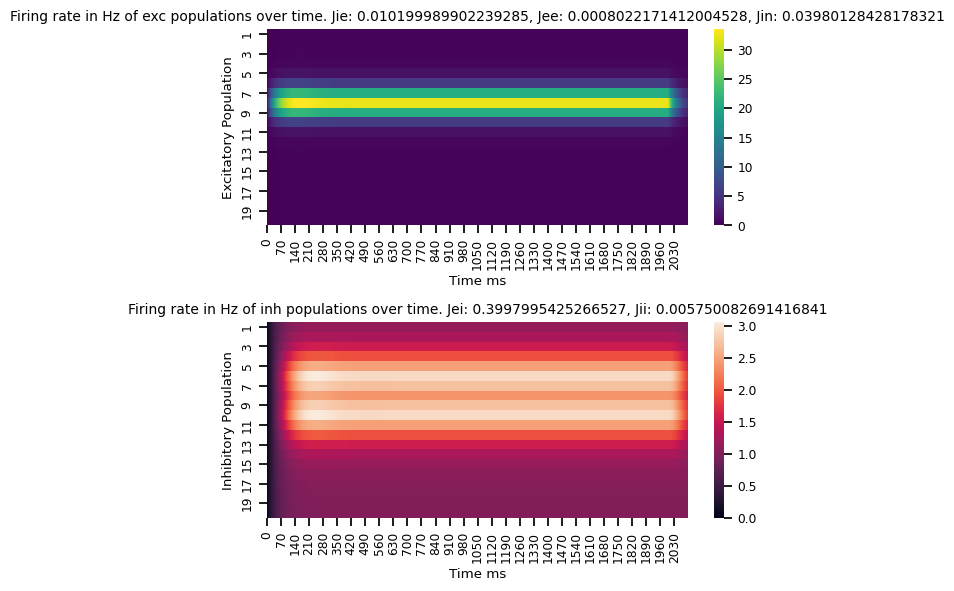

In [122]:

trained_bad_model, optimizer_bad_trained = model_with_saved_trained_param(mybadmodel, optimizer, BadParamModel)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ RUN forward pass and Print heatmap ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

r_e_bad_trained, r_i_bad_trained, dredt_bad_trained, dridt_bad_trained = trained_bad_model.forward(sti) #Xtrain_tensor[2,:,:]
ic(torch.max(r_e_bad))
ic(torch.max(r_e_bad_trained))

#J1 = {'Jee': mymodel.Jee.detach().numpy(), 'Jei': mymodel.Jei.detach().numpy(), 'Jie': mymodel.Jie.detach().numpy(), 'Jii': mymodel.Jii.detach().numpy(), 'Jin': trained_model.Jin.detach().numpy()}
HeatMap(r_e_bad.detach().numpy(), r_i_bad.detach().numpy(), J_bad)
J2= {'Jee': trained_bad_model.Jee.detach().numpy(), 'Jei': trained_bad_model.Jei.detach().numpy(), 'Jie': trained_bad_model.Jie.detach().numpy(), 'Jii': trained_bad_model.Jii.detach().numpy(), 'Jin': trained_bad_model.Jin.detach().numpy()}
HeatMap(r_e_bad_trained.detach().numpy(), r_i_bad_trained.detach().numpy(), J2)